In [1]:
from rds2py import read_rds
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# loading .csv and .rds files
player_mins = pd.read_csv('atlutd_datascientist_project2_player_mins_appearances.csv')
schedule = pd.read_csv('atlutd_datascientist_project2_schedule.csv')

r_obj = read_rds("atlutd_datascientist_project2_eventdata.rds")

/Users/koverman/Library/Python/3.9/lib/python/site-packages/rds2py/generics.py:137: RuntimeWarning: RDS file contains an unknown class: 'tbl_df', returning the dictionary
  warn(


In [2]:
#converting .rds to a dataframe

df = pd.DataFrame(r_obj['data'])
attr = pd.DataFrame(r_obj['attributes'])
df = pd.DataFrame(df['data'].tolist()).T
df.columns = attr['names'].data

In [3]:
# an additional dataframe to access assist information from r_obj
col_names = r_obj["attributes"]["names"]["data"]

# Extract data, handling nested structures
data = {}
for col_name, col_data in zip(col_names, r_obj["data"]):
    raw_values = col_data["data"]

    if isinstance(raw_values, list):
        series = pd.Series(raw_values)

        # any empty entries should be nan's
        if col_data["type"] == "string":
            series = series.replace("", np.nan)

        # use assisted_shot_id to populate the column
        if col_name in ["pass.shot_assist", "pass.goal_assist", "shot.shot_shot_assist", "shot.shot_goal_assist"]:
            data[col_name] = np.nan  # nan when not assist

        elif col_name == "pass.assisted_shot_id":
            # If assisted_shot_id exists, mark pass.shot_assist = True
            data["pass.shot_assist"] = series.notna().astype("boolean")

        else:
            data[col_name] = series  # Keep as-is for other columns

# store in dataframe
assist_df = pd.DataFrame(data)
assist_df = assist_df.merge(df[['id', 'player.id']],how='right',on='id')


In [4]:
player_mins.describe()

,Unnamed: 0,player_id,team_id,player_season_appearances,player_season_minutes
count,664.000000,664.000000,664.000000,664.000000,664.000000
mean,332.500000,144031.328313,6660.998494,5.081325,373.072289
std,191.824573,156312.296205,8571.185530,2.823519,275.174615
min,1.000000,3109.000000,1645.000000,1.000000,3.733333
25%,166.750000,37218.750000,1901.000000,3.000000,128.591665
50%,332.500000,51662.500000,2335.000000,5.000000,322.000020
75%,498.250000,214006.750000,3376.000000,7.000000,567.158338
max,664.000000,463118.000000,26022.000000,10.000000,1037.166600


In [5]:
# choosing to look at players that played over 70 minutes in forward/attacking positions
ids_over70min = player_mins[(player_mins['player_season_minutes']/player_mins['player_season_appearances']>70) & (player_mins['player_season_appearances']>2)].player_id.values

positions = ['Center Forward', 'Right Center Forward', 'Left Center Forward','Center Attacking Midfield','Right Attacking Midfield', 'Left Attacking Midfield']
attack_over70min_players = df[(df['player.id'].isin(ids_over70min)) & (df['position.name'].isin(positions))].drop_duplicates()

In [6]:
#attackers_summary will contain the metrics I decide to evaluate the forwards with
attackers_summary = pd.DataFrame()
attackers_summary['player_id'] = np.unique(attack_over70min_players['player.id'].values.astype(float))

In [7]:
# Group by 'player.id' and compute metrics for each player
tmp = df.groupby('player.id').agg(
    shots_taken=('shot.outcome.name', lambda x: np.count_nonzero(x != '')),
    goals_scored=('shot.outcome.name', lambda x: np.count_nonzero(x == 'Goal')),
    avg_xg_shots=('shot.shot_execution_xg', lambda x: x.astype(float).dropna().mean()),
    avg_pass_success_probability=('pass.pass_success_probability', lambda x: x.astype(float).dropna().mean()),
    offside_events=('type.name', lambda x: np.count_nonzero(x == 'Offside')),
    fouls_committed=('foul_committed.type.name', lambda x: np.count_nonzero(~x.isin(['', 'Backpass Pick']))),
    foul_cards=('foul_committed.card.name', lambda x: np.count_nonzero(x != '')),
    behavior_cards=('bad_behaviour.card.name', lambda x: np.count_nonzero(x != ''))
).reset_index()

# sum foul and behavior cards for total cards
tmp['total_cards'] = (tmp['foul_cards'] + tmp['behavior_cards'])

# use player_minutes to calculate usage (avg number of minutes in a game)
tmp = tmp.merge(player_mins[['player_id', 'player_season_minutes', 'player_season_appearances']],left_on='player.id', right_on='player_id', how='left')
tmp['usage'] = ( tmp['player_season_minutes'] / tmp['player_season_appearances'])

# Drop columns no longer needed or potentially duplicates
tmp = tmp.drop(columns=['player_season_minutes', 'player_season_appearances', 'player_id'])

# use assist_df to calculate a player's number of assists (whether or not the shot went in)
shot_assists = assist_df.groupby('player.id').agg(shot_assists=('pass.shot_assist', lambda x: np.count_nonzero(x == True))).reset_index()
tmp = tmp.merge(shot_assists[['player.id', 'shot_assists']], on='player.id', how='left')

# Merge the computed metrics back into attackers_summary
attackers_summary = attackers_summary.merge(tmp, left_on='player_id', right_on='player.id', how='left').drop(columns=['player.id'])

del tmp

In [8]:
attackers_summary.head(5)

,player_id,shots_taken,goals_scored,avg_xg_shots,avg_pass_success_probability,offside_events,fouls_committed,foul_cards,behavior_cards,total_cards,usage,shot_assists
0,3109.0,18,2,0.124029,0.821107,0,0,0,0,0,90.564822,19
1,3265.0,20,4,0.151752,0.764532,1,0,0,2,2,100.789581,3
2,3535.0,24,4,0.208349,0.789403,1,0,0,0,0,75.607411,7
3,3629.0,16,1,0.118290,0.792890,1,0,0,0,0,89.220367,16
4,3814.0,24,8,0.257788,0.787885,0,0,0,0,0,97.796660,35


In [9]:
# selecting columns for analysis or transformation
metrics = attackers_summary.columns.drop('player_id')
to_invert = ['offside_events', 'fouls_committed', 'foul_cards', 'behavior_cards', 'total_cards'] #when these are high, that's bad. would like to invert to reflect that

# scaling all metrics
scaler = StandardScaler()
df_scaled = attackers_summary.copy()
df_scaled[to_invert] = -1*df_scaled[to_invert] #inverting the metrics that are better when low
df_scaled[metrics] = scaler.fit_transform(df_scaled[metrics])

# run PCA to get reduce dimensionality and get player ranking
pcs = PCA(n_components=1)
df_scaled['PCS_score'] = pcs.fit_transform(df_scaled[metrics])

pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_scaled[metrics])

In [10]:
# Get top 3 players based on PCS score
top_players = df_scaled.nlargest(3, 'PCS_score')[['player_id', 'PCS_score']]

# Explained variance by PC1
# explained_variance = pca.explained_variance_ratio_[0]

print("Top players using PCS ranking:\n", top_players)
# print(f"\nPC1 explains {explained_variance:.2%} of the variance in the data.")


Top players using PCS ranking:
     player_id  PCS_score
41    37649.0   5.621344
4      3814.0   4.461757
7      5187.0   3.979975


In [11]:
attackers_summary[attackers_summary['player_id'].isin([37649.0, 3814.0, 5187.0])]

,player_id,shots_taken,goals_scored,avg_xg_shots,avg_pass_success_probability,offside_events,fouls_committed,foul_cards,behavior_cards,total_cards,usage,shot_assists
4,3814.0,24,8,0.257788,0.787885,0,0,0,0,0,97.796660,35
7,5187.0,29,8,0.209780,0.774750,0,0,0,0,0,99.391660,22
41,37649.0,36,9,0.273214,0.800564,2,3,1,0,1,90.038878,14


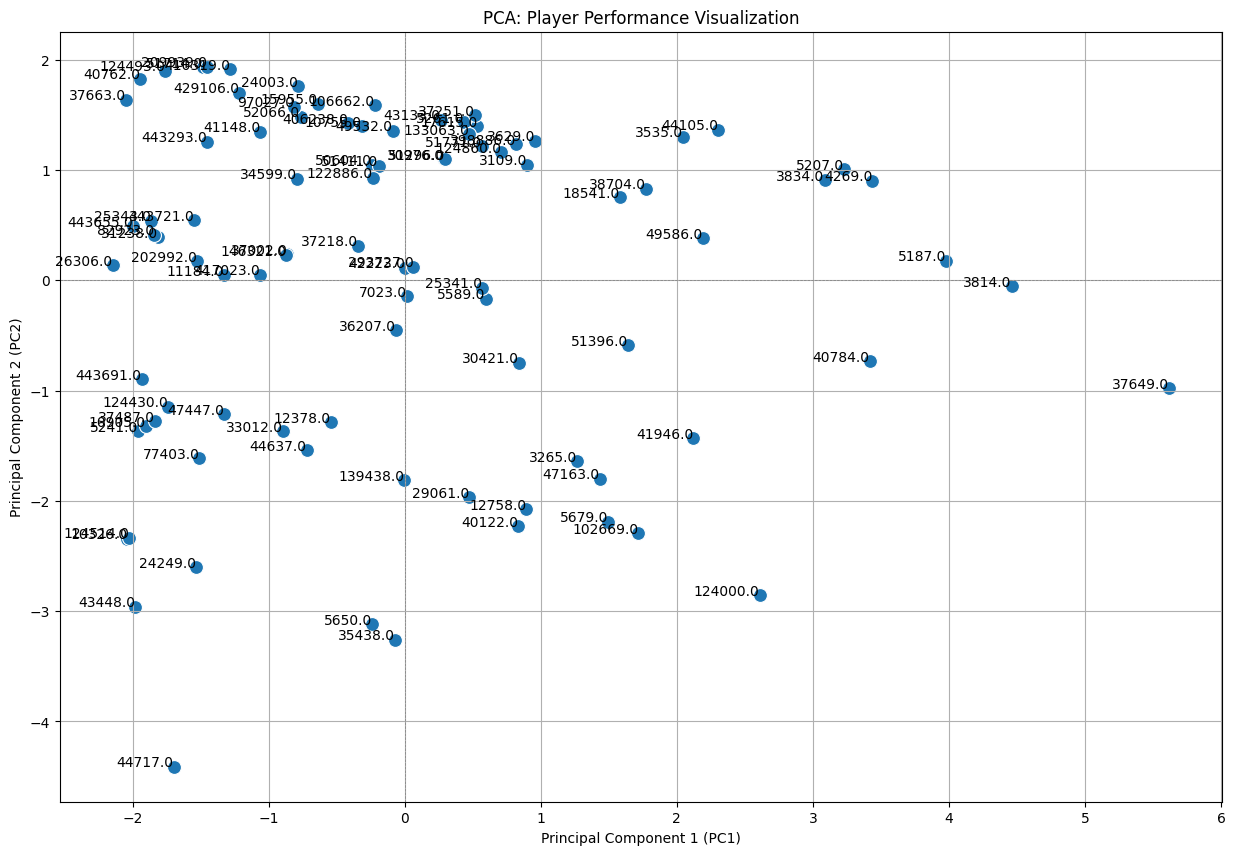

In [12]:
# Create a new DataFrame for plotting
df_pca = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
df_pca['player_id'] = df_scaled['player_id']

# Plot the principal components
plt.figure(figsize=(15, 10))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', s=100)

#label with player_ids
for i, row in df_pca.iterrows():
    plt.text(row['PC1'], row['PC2'], str(row['player_id']), fontsize=10, ha='right')
    
# Formatting
plt.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
plt.title("PCA: Player Performance Visualization")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.grid(True)
plt.show()

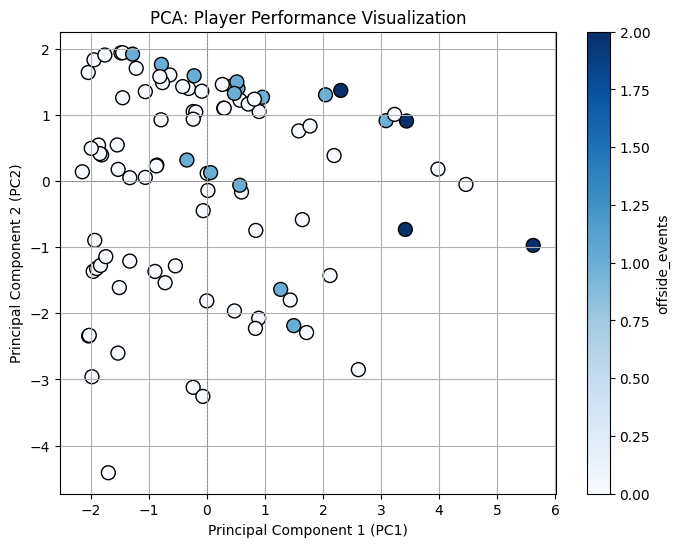

In [13]:
#this cell I ran for multiple different metrics to produce figures for the presentation

# choose a metric that may correlate to one of the PCs
pc_guess = 'offside_events'
df_pca[pc_guess] = attackers_summary[pc_guess]  # Ensure attackers_summary is defined


# scatter plot with a colormap according to the chosen metric
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca[pc_guess], cmap='Blues', edgecolors='black', s=100)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label(pc_guess)

# formatting
ax.axhline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.axvline(0, color='gray', linestyle='dashed', linewidth=0.5)
ax.set_title("PCA: Player Performance Visualization")
ax.set_xlabel("Principal Component 1 (PC1)")
ax.set_ylabel("Principal Component 2 (PC2)")
ax.grid(True)

plt.show()
